# IUM PROJEKT

## Autorzy
Mateusz Krakowski \
Grzegorz Socha

## Słowniczek

kliknięcie - wykonanie operacji "PLAY" przez użytkownika \
interwał czasowy - odstęp w skwantowanym czasie

## Kontekst
Portal muzyczny „Pozytywka”, który swoim użytkownikom pozwala na odtwarzanie ulubionych utworów
online.
### Zadanie
“Nasz serwis zarabia wtedy, gdy ludzie słuchają muzyki. Jeśli nie wiemy ile czasu będą słuchali
jej w przyszłości, to trudno nam rozliczać się z artystami i negocjować z nimi stawki”.

## Problem biznesowy
Nasz serwis, jak większość popularnych serwisów streamingowych działa w modelu "freemium" - darmowy dostęp do serwisu okraszonego reklamami z możliwością pozbycia się ich poprzez zakupienie premium. Serwis musi płacić artystom należną im kwotę ustaloną wcześniej. Naszym zadaniem jest stworzenie modelu predykcyjnego, który pozwoli na oszacowanie jak wiele "kliknięć" przyciągnie twórczość danego artysty. Dzięki predykcji portal "Pozytywka" będzie miał ułatwienie w podejmowaniu decyzji odnośnie wysokości stawek dla artystów.

Interesują nas tutaj kliknięcia zamiast pełnych wysłuchań utworów, gdyż zakładamy że to właśnie kliknięcie może wywołać reklamę, a co za tym idzie przynieść zyski.

## Biznesowe kryterium sukcesu
Otrzymanie predykcji które ułatwią portalowi "Pozytywka" podejmowanie decyzji w sprawie kontraktów z artystami. W przypadku spadającej popularności artysty portal będzie mógł zerwać kontrakt, w przypadku rosnącej popularności portal będzie mógł pozwolić na zwiększenie stawki.

## Zadanie modelowania:
Musimy rozwiązać problem analizy szeregów czasowych w celu przewidzenia ilości odtworzeń
utworów danego artysty w przyszłości. Na podstawie predykcji modelu będziemy mogli ustalić,
czy artysta będzie zyskiwał na popularności, a co za tym idzie, czy możemy pozwolić na zwięk-
szenie jego stawki kwotowej.
W celu rozwiązania problemu stworzone zostaną dwa modele predykcyjne:
- zaawansowany model korzystający z metody ARIMA
- prosty model naiwny

Danymi wejściowymi będą wartości ilości kliknięć utworów poszczególnych artystów w każdym z interwałów czasowych. Obecnie proponujemy interwały miesięczne dlatego, że na rynku europejskim popularne jest rozliczanie się co miesiąc. \
Zmienną celu jest ilość kliknięć użytkowników które przyciągnęła twórczość danego artysty w przyszłych miesiącach, które możemy szacować przez predykcję.

## Analityczne kryterium sukcesu
Otrzymanie predykcji z błędem nie przekraczającym wartości alfa. MSE(error) = alfa. alfa = 300.
Błąd możemy obliczyć poprzez nieuwzględnienie ostatniego interwału czasowego w modelu, w celu porównania predykcji do danych które mamy.

## Analiza otrzymanych danych pod względem poprawności
Pełna analiza w oddzielnych plikach

## Dane v1

Na drodze analizy przysłanych danych odkryliśmy następujące błędy:

- 327 artystów z bazy jako id ma podaną wartość "-1" np. "Skrillex" czy "Earth, Wind and Fire"
- wiele rekordów sesji użytkowników jest wybrakowana, brakuje takich pól jak: user\_id, track\_id, event\_type(przyjmują wartość null)
- podobny problem występuje w danych piosenek, tym razem wartości null występują w polach: id, name, popularity, id\_artist

Dodatkowo danych sesji jest za mało aby dokonywać predykcji na temat popularności piosenek. \
Niestety, przysłane dane nie pozwolą na rozwiązanie problemu. Wymagane było ponowne poproszenie o dane.


## Dane v2

Na drodze analizy udało nam się ustalić że dane są kompletne oraz wyeliminowano błędy opisane w v1, Dodatkowo:
- zwiększyła się ilość artystów oraz utworów
- kluczowa dla nas jest duża ilość danych sesji użytkowników, porównując do poprzedniej wersji danych
- dane sesji dotyczą jedynie 808 artystów z bazy 28 tysięcy, oznacza to, że proponowany przez nas model możemy zastosować jedynie do tych 808 artystów.
- Na dodatek jedynie 491/808 artystów zostało wysłuchanych przynajmniej raz w każdym z miesiąców. \

## Wnioski z analizy danych:
- Możemy dokonywać predykcji
- predykcje mogą być wykonywane tylko dla artystów dla których mamy wystarczająco dużo danych
- predykcje powinnybyć lepsze dla popularnych artystów
- lepiej by było gdybyśmy mieli pełne dane sesji użytkowników, nie tylko wybrane(808/27524 artystów posiadających wysłuchania ich utworów, ciężko uwieżyć że nikt nie słuchał np. Skrillexa)


# ETAP 2


## Dane v3

- Danych sesji jest 20 razy więcej, dodatkowo dotyczą dłuższego okresu czasowego (2019-07-15 do 2023-01-09)
- nie zmieniła się liczba artystów, którzy zostali wysłuchani chociaż raz.
- zmieniła się liczba artystów, którzy zostali wysłuchani chociaż raz w każdym z miesiąców działania Pozytywki 656/808 (pomijając lipiec 2019 oraz styczeń 2023, gdyż nie posiadamy danych z całego miesiąca)
## Wnioski z analizy danych:
- Możemy dokonywać predykcji
- predykcje mogą być wykonywane tylko dla artystów dla których mamy dane, nadal jest to  808 artystów z 27524. 
- predykcje powinnybyć lepsze dla popularnych artystów
- Dzięki dłuższemu zasięgowi dat w danych, predykcje otrzymywane od modelu zaawansowanego powinny być lepsze



In [1]:
import pandas as pd
from dateutil import parser
from datetime import date
import matplotlib.pyplot as plt
import json

In [2]:
ARTISTS_FILE = "data/v3/artists.jsonl"
SESSIONS_FILE = "data/v3/sessions.jsonl"
SESSIONS_PLAY_FILE = "data/v3/sessions_play.jsonl"
TRACKS_FILE = "data/v3/tracks.jsonl"
ARTIST_CLICKS_PER_MONTH_FILE ='data/v3/artists_clicks_per_month.json'


## Preprocessing danych

In [3]:
import json
with open(SESSIONS_FILE) as f:
    # save sessions that have event_type "PLAY" to new file
    with open(SESSIONS_PLAY_FILE, "w") as f2:
        for line in f:
            session = json.loads(line)
            if session["event_type"] == "PLAY":
                f2.write(line)
                



In [4]:
artists = pd.read_json(ARTISTS_FILE, lines=True)
sessions = pd.read_json(SESSIONS_PLAY_FILE, lines=True)
tracks = pd.read_json(TRACKS_FILE, lines=True)

pd.set_option('mode.chained_assignment', None)

## Funkcje pomocnicze do analizy danych


Z danych wynika, że pozytywka rozpoczeła swoją działalność w 2019 roku. Gdyby to było błędem, należy zmienić stałą FIRST_YEAR na poprawny rok.

In [5]:
FIRST_YEAR = 2019

def get_month(date):
    return date.month + (date.year - FIRST_YEAR) * 12


def month_to_year_month(month):
    year = FIRST_YEAR + (month - 1) // 12
    month = (month - 1) % 12 + 1
    return f"{year}-{month:02d}"

## Analiza danaych pod względem rozwiązania

In [6]:
# Sort by timestamp
sessions = sessions.sort_values(by=['timestamp'])

# dane podzielimy na miesiące po to aby zachować regularność
sessions

,timestamp,user_id,track_id,event_type,session_id
1269842,2019-07-15 04:42:09.294229,164,2KiW2M0f0F9qNI0HdCCc7P,PLAY,56730
1269843,2019-07-15 04:42:15.090229,164,5rWMxk6HfjqBhE2yawpk0W,PLAY,56730
1269844,2019-07-15 04:42:30.596229,164,5FyRmetoS11VeXj3hOxIkt,PLAY,56730
1269845,2019-07-15 04:45:39.663229,164,73hp2q8wDbf9A8Zi6KZLfZ,PLAY,56730
1269846,2019-07-15 04:49:08.770229,164,13CtMmnEyGZ15US2ZfW662,PLAY,56730
...,...,...,...,...,...
9585473,2023-01-09 01:50:03.747946,526,5vjLSffimiIP26QG5WcN2K,PLAY,427168
11072155,2023-01-09 01:51:35.070519,591,5uCax9HTNlzGybIStD3vDh,PLAY,493271
1167325,2023-01-09 01:55:00.754706,158,0v1hfv2mSLoagpZtrMDn11,PLAY,52169
11072156,2023-01-09 01:55:06.537519,591,7qEHsqek33rTcFNT9PFqLf,PLAY,493271


In [7]:
# zakres od 2019-07-15 do 2023-01-09, usuwany dane z lipca 2019 i stycznia 2023 gdyż nie są pełne
sessions = sessions[sessions['timestamp'] > '2019-08-01']
sessions = sessions[sessions['timestamp'] < '2023-01-01']


sessions

,timestamp,user_id,track_id,event_type,session_id
2772627,2019-08-01 07:31:35.905492,231,6Ozh9Ok6h4Oi1wUSLtBseN,PLAY,123539
2772628,2019-08-01 07:34:15.620492,231,0pqnGHJpmpxLKifKRmU6WP,PLAY,123539
2772629,2019-08-01 07:37:39.967492,231,1EzrEOXmMH3G43AXT1y7pA,PLAY,123539
2772630,2019-08-01 07:41:42.154492,231,5uCax9HTNlzGybIStD3vDh,PLAY,123539
2772631,2019-08-01 07:45:13.621492,231,2RttW7RAu5nOAfq6YFvApB,PLAY,123539
...,...,...,...,...,...
2900937,2022-12-31 23:59:49.456280,234,3ZCTVFBt2Brf31RLEnCkWJ,PLAY,129276
5041757,2022-12-31 23:59:52.142691,319,49rcSzMayJhIwGf0CJCaxJ,PLAY,224796
4760331,2022-12-31 23:59:54.000930,307,4kLLWz7srcuLKA7Et40PQR,PLAY,212198
5367346,2022-12-31 23:59:54.554052,333,3ee8Jmje8o58CHK66QrVC2,PLAY,239313


In [8]:


# merge sessions played with tracks and artists
sessions = sessions.merge(tracks, left_on='track_id', right_on='id', how='left')
sessions = sessions.merge(artists, left_on='id_artist', right_on='id', how='left')


In [9]:

# change name of columm name_y to artist, name_x to track
sessions = sessions.rename(columns={'name_y': 'artist', 'name_x': 'track'})

# count the number of all unique artisits
unique_artists = sessions['artist'].unique()

sessions['month'] = sessions['timestamp'].apply(get_month)

artist_clicks = sessions.groupby(['artist', 'month']).size().reset_index(name='play_count')


artist_clicks

print(f"unique artists: {len(unique_artists)}")


unique artists: 808


In [10]:
artist_clicks_dictionary = {}
artist_lisined_to_every_month = []

max_month = max(artist_clicks['month'])
min_month = min(artist_clicks['month'])

for artist in unique_artists:
    artist_clicks_dictionary[artist] = artist_clicks[artist_clicks['artist'] == artist].drop(columns=['artist']).set_index('month').to_dict()['play_count']

    if len(artist_clicks_dictionary[artist]) == max_month - min_month + 1:
        artist_lisined_to_every_month.append(artist)


# if artist listened to every month add to list


for artist in artist_clicks_dictionary:
    if len(artist_clicks_dictionary[artist]) < 12:


        for i in range(min_month, max_month+1):
            if i not in artist_clicks_dictionary[artist]:
                artist_clicks_dictionary[artist][i] = 0
    

print(f"Number of artists that were listened to every month: {len(artist_lisined_to_every_month)}")



Number of artists that were listened to every month: 656


## Poprawienie czytelności danych (ETAP 2)

In [11]:
# if a month is not in dictionary add it with value 0
for artist in artist_clicks_dictionary:
    for i in range(min_month, max_month+1):
        if i not in artist_clicks_dictionary[artist]:
            artist_clicks_dictionary[artist][i] = 0

#sort dictionary by month
for artist in artist_clicks_dictionary:
    artist_clicks_dictionary[artist] = dict(sorted(artist_clicks_dictionary[artist].items()))
  
# switch month to date
for artist in artist_clicks_dictionary:
    artist_clicks_dictionary[artist] = {month_to_year_month(month): value for month, value in artist_clicks_dictionary[artist].items()}

with open(ARTIST_CLICKS_PER_MONTH_FILE, 'w') as fp:
    json.dump(artist_clicks_dictionary, fp)


## Dane wejściowe
Będzie to słownik których kluczem będzie nazwa artysty/zespołu, natomiast wartością będzie kolejny słownik, tym razem z parami miesiąc:ilość kliknięć. 
Przykład elementu słownika:



In [12]:
artist_clicks_dictionary["XXXTENTACION"]


{'2019-08': 111,
 '2019-09': 337,
 '2019-10': 625,
 '2019-11': 827,
 '2019-12': 837,
 '2020-01': 1052,
 '2020-02': 1161,
 '2020-03': 1475,
 '2020-04': 1513,
 '2020-05': 1851,
 '2020-06': 1942,
 '2020-07': 2162,
 '2020-08': 2616,
 '2020-09': 2772,
 '2020-10': 3139,
 '2020-11': 3089,
 '2020-12': 3601,
 '2021-01': 3980,
 '2021-02': 3671,
 '2021-03': 4325,
 '2021-04': 4227,
 '2021-05': 4729,
 '2021-06': 4995,
 '2021-07': 5018,
 '2021-08': 5118,
 '2021-09': 4853,
 '2021-10': 5441,
 '2021-11': 5206,
 '2021-12': 5485,
 '2022-01': 6165,
 '2022-02': 5739,
 '2022-03': 6202,
 '2022-04': 6387,
 '2022-05': 6643,
 '2022-06': 6373,
 '2022-07': 7391,
 '2022-08': 7219,
 '2022-09': 7132,
 '2022-10': 8121,
 '2022-11': 7426,
 '2022-12': 7948}

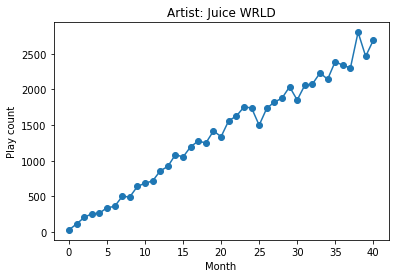

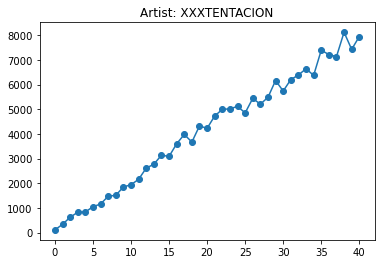

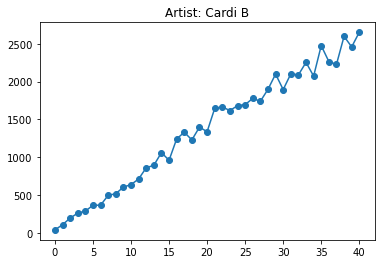

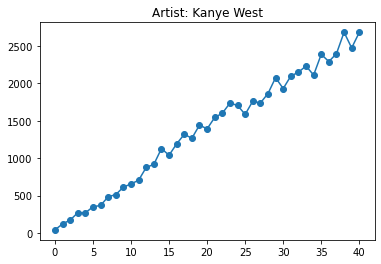

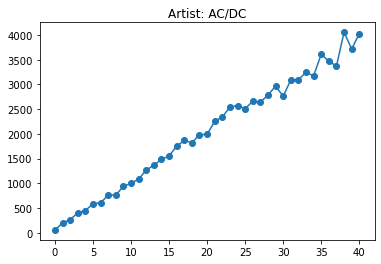

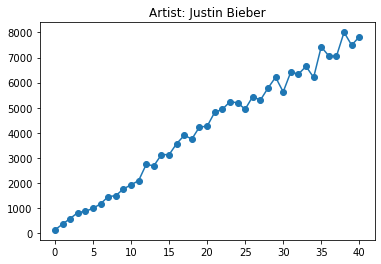

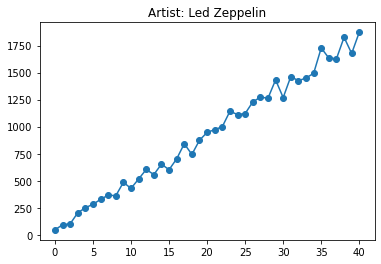

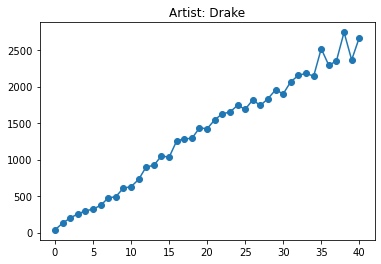

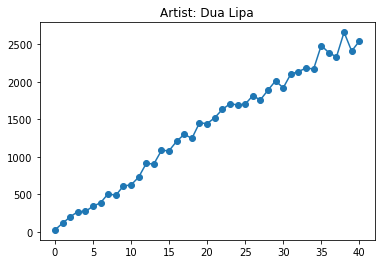

In [13]:
NUMBER_OF_ARTISTS_TO_PLOT = 10
ARTISTS_POPULAR = ["Kanye West", "Justin Bieber", "Juice WRLD", "Dua Lipa", "Drake", "Cardi B", "Led Zeppelin", "AC/DC", "XXXTENTACION"]
ARTISTS_LESS_POPULAR = ["Amorphis", "Angra", "Biffy Clyro", "Beck", "Ghost", "Viola Beach", "Gov't Mule"]
fully_plotted_artists = []
plt.xlabel("Month")
plt.ylabel("Play count")
#plot artists from artists_clicks_dictionary
for artist in artist_clicks_dictionary:
    if len(fully_plotted_artists) < NUMBER_OF_ARTISTS_TO_PLOT:
        if artist in ARTISTS_POPULAR:
            plt.title(f"Artist: {artist}")
            plt.plot(artist_clicks_dictionary[artist].values(), label=artist ,marker='o')
            plt.show()
            fully_plotted_artists.append(artist)






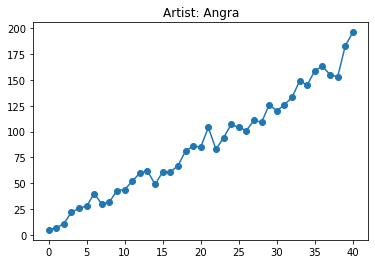

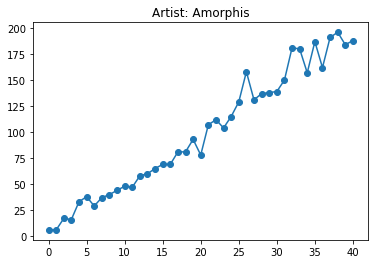

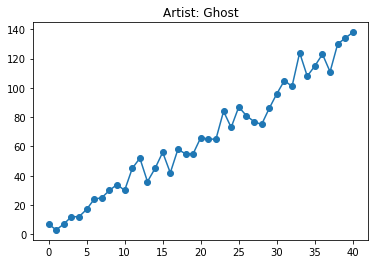

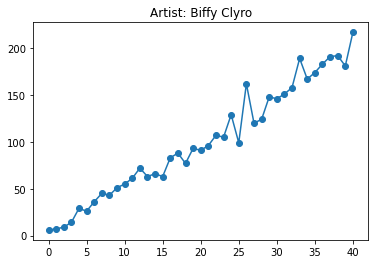

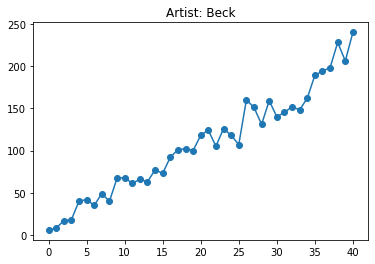

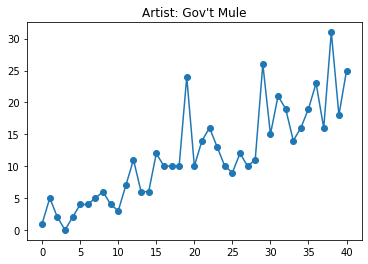

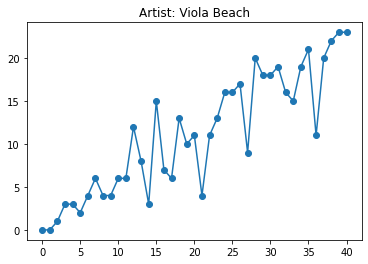

In [14]:
NUMBER_OF_ARTISTS_TO_PLOT = 10

fully_plotted_artists = []

for artist in artist_clicks_dictionary:
    if len(fully_plotted_artists) < NUMBER_OF_ARTISTS_TO_PLOT:
        if artist in ARTISTS_LESS_POPULAR:
            plt.title(f"Artist: {artist}")
            plt.plot(artist_clicks_dictionary[artist].values(), label=artist ,marker='o')
            plt.show()
            fully_plotted_artists.append(artist)

### Wnioski z analizy danych:

Widoczny jest stabilny wzrost popularności z miesiąca na miesiąc dla twórców o dużej renomie, tego samego nie można powiedzieć o artytstach mniej popularnych. Zauważalny jednak jest trend wzrostowy, mimo wachań w ilościach wysłuchań.

## Dalsze działania:
- Zastosowanie modeli predykcyjnych
- zwiększenie ilości danych


# ETAP 2

## Dane v3

- Danych sesji jest 20 razy więcej, dodatkowo dotyczą dłuższego okresu czasowego (2019-07-15 do 2023-01-09)
- nie zmieniła się liczba artystów, którzy zostali wysłuchani chociaż raz.
- zmieniła się liczba artystów, którzy zostali wysłuchani chociaż raz w każdym z miesiąców działania Pozytywki 656/808 (pomijając lipiec 2019 oraz styczeń 2023, gdyż nie posiadamy danych z całego miesiąca)
## Wnioski z analizy danych:
- Możemy dokonywać predykcji
- predykcje mogą być wykonywane tylko dla artystów dla których mamy dane, nadal jest to  808 artystów z 27524. 
- predykcje powinny być lepsze dla popularnych artystów
- Dzięki dłuższemu zasięgowi dat w danych, predykcje otrzymywane od modelu zaawansowanego powinny być lepsze


## Poprawiono:

### Kryterium sukcesu
Uznaliśmy, że najlepiej będzie badać procentowy wzrost popularności artystów, z tego powodu kryterium sukcesu definiujemy jako otrzymanie błędu MAE(error) < 5. Będzie to oznaczało, że nasz model predykcyjny myli się średnio co do +/- 5 procent jeśli chodzi o zwiększenie/zmniejszenie się popularności danego artysty.

### Reprezentacja danych
Poprawiono czytelność danych, teraz kluczem w słowniku artist_clicks_per_month jest para ROK-MIESIĄC, wartością nadal suma kliknięć w danym miesiącu. 
  
## Modele predykcyjne
Na początku musimy wybrać zaawansowany model predykcyjny, porównamy działanie ARIMA oraz ExponentialSmoothing. Jako najprostszy model wybraliśmy model naiwny.

Warto wspomnieć, że naszym zadaniem nie jest przewidzenie dokładnej wartości przesłuchań w kolejnych miesiącach, a raczej procentowej wartości zwiększenia popularności danego artysty.
Przez model przepuszczane są wszystkie miesiące, w których są pełne dane prócz ostatniego miesiąca. Dzięki temu zabiegowi jakość predykcji możemy oceniać na podstawie wyliczonego MSE, błąd między predykcją procentowego wzrostu popularności danego artysty z modelu, a faktycznym stanem rzeczy.

Na końcu tego etapu eksportowane są modele ARIMA oraz model naiwny, aby móc je wykorzystać w implementacji mikroserwisu.



### Implementacja modelu naiwnego

In [15]:
class NaiveModel:
    def __init__(self, data):
        self.data = data

    def predict(self, months: int):
        if months < 1:
            raise ValueError('months must be greater than 0')
        if months == 1:
            return self.data[-1]
        
        return [self.data[-1] for _ in range(months)] 

    


In [16]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import pandas as pd
from copy import deepcopy
import numpy as np
import json
plt.rcParams["figure.figsize"] = (25, 15)

ARTIST_CLICKS_PER_MONTH_FILE ='data/v3/artists_clicks_per_month.json'




### Funkcje pomocnicze

In [17]:
def calculate_MSE_loss(real, predicted):
    return np.mean((real - predicted)**2)

def calculate_MAE_loss(real, predicted):
    return np.mean(abs(real - predicted))

def get_percent_growth(value, new_value):
    return (new_value - value) / abs(value) * 100



### Otwieramy dane przygotowane w ETAP1

In [18]:
with open(ARTIST_CLICKS_PER_MONTH_FILE, 'r') as fp:
    artist_clicks_dictionary = json.load(fp)

artist_clicks_series = pd.Series(artist_clicks_dictionary)

artist_clicks_series

DaBaby             {'2019-08': 37, '2019-09': 106, '2019-10': 215...
Imagine Dragons    {'2019-08': 93, '2019-09': 240, '2019-10': 445...
Jason Mraz         {'2019-08': 34, '2019-09': 100, '2019-10': 205...
James Arthur       {'2019-08': 31, '2019-09': 115, '2019-10': 205...
Ed Sheeran         {'2019-08': 109, '2019-09': 334, '2019-10': 59...
                                         ...                        
Sacred Reich       {'2019-08': 0, '2019-09': 0, '2019-10': 0, '20...
R.L. Burnside      {'2019-08': 0, '2019-09': 0, '2019-10': 0, '20...
Lizzy Borden       {'2019-08': 0, '2019-09': 0, '2019-10': 0, '20...
Warlord            {'2019-08': 0, '2019-09': 0, '2019-10': 0, '20...
YUNGBLUD           {'2019-08': 0, '2019-09': 0, '2019-10': 0, '20...
Length: 808, dtype: object

## Wykonywanie predykcji dla wybranego artysty (wystarczy zmienić ARTIST)

In [32]:
ARTIST = "XXXTENTACION"
PRED_PERIODS = 12

data = deepcopy(artist_clicks_series[ARTIST])
last_month = data.popitem()
last_month_value = last_month[1]

data = pd.Series(data)

print(data)

2019-08     111
2019-09     337
2019-10     625
2019-11     827
2019-12     837
2020-01    1052
2020-02    1161
2020-03    1475
2020-04    1513
2020-05    1851
2020-06    1942
2020-07    2162
2020-08    2616
2020-09    2772
2020-10    3139
2020-11    3089
2020-12    3601
2021-01    3980
2021-02    3671
2021-03    4325
2021-04    4227
2021-05    4729
2021-06    4995
2021-07    5018
2021-08    5118
2021-09    4853
2021-10    5441
2021-11    5206
2021-12    5485
2022-01    6165
2022-02    5739
2022-03    6202
2022-04    6387
2022-05    6643
2022-06    6373
2022-07    7391
2022-08    7219
2022-09    7132
2022-10    8121
2022-11    7426
dtype: int64


### Dane które otrzyma model

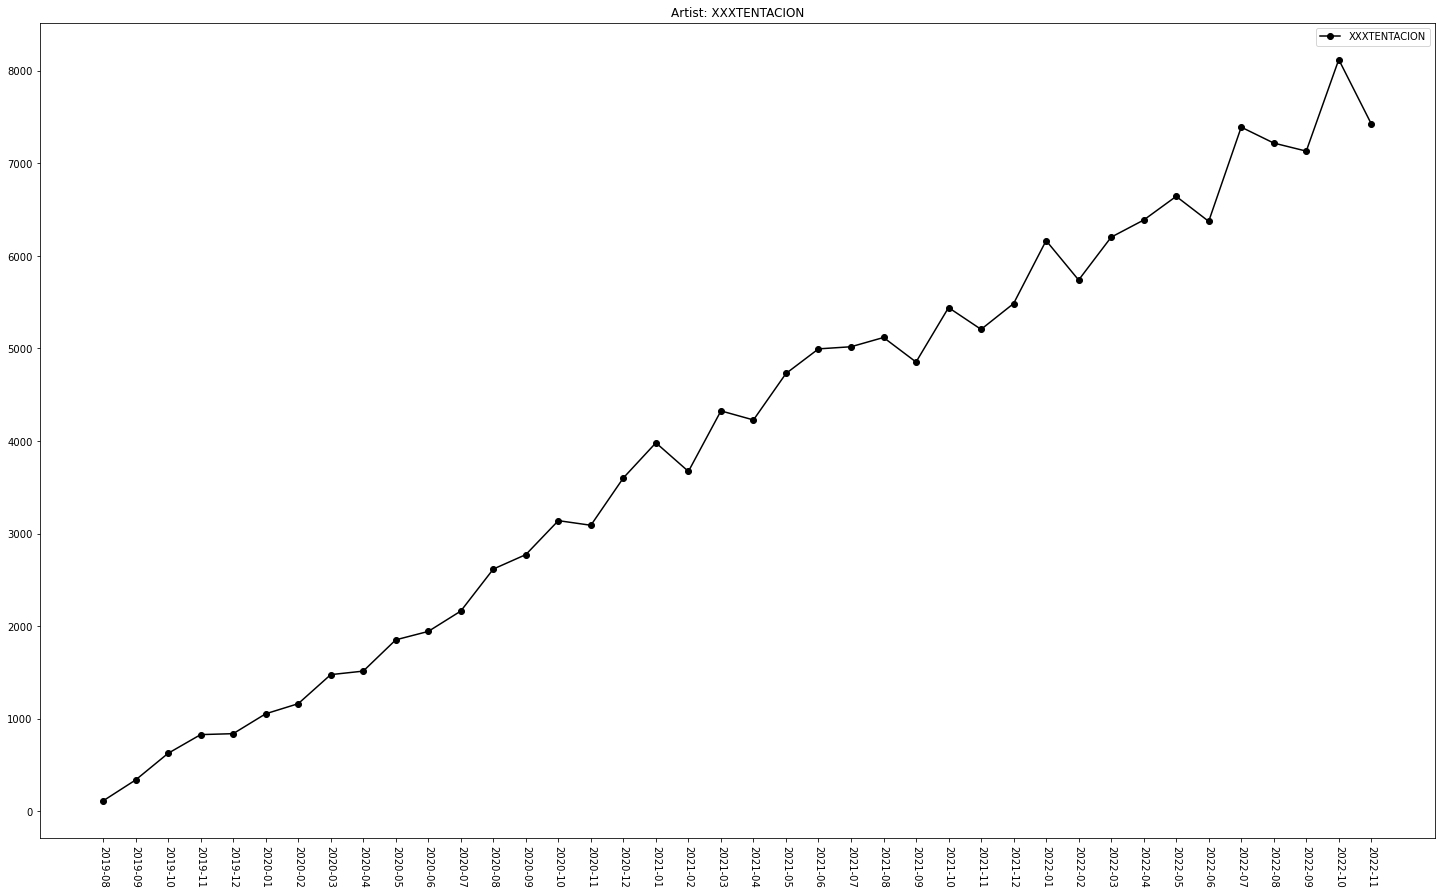

In [33]:
plt.title(f"Artist: {ARTIST}")
plt.plot(data, label=ARTIST ,marker='o', color='black')
plt.xticks(rotation=270)
plt.legend()

plt.show()

In [34]:
def date_to_month(date):
    return date.strftime('%Y-%m')

In [35]:

#get next mounth from data

arima_model = auto_arima(data, trend='t', max_d=3, max_P=3, max_Q=3, max_order=None, seasonal=True, frequency="MS",  stepwise=True)
arima_model.fit(data)
arima_predictions = arima_model.predict(n_periods=PRED_PERIODS)


print(f"Predicted values for {ARTIST} REAL DATA: {last_month_value} Prediction : {arima_predictions}")

# format data to be able to plot it
data_arima_predicted = pd.Series(arima_predictions, index= date_to_month(pd.date_range(date_to_month(pd.to_datetime(data.keys()[-1]) + pd.DateOffset(months=1)), periods=12, freq='MS')))
print(data_arima_predicted)

Predicted values for XXXTENTACION REAL DATA: 7948 Prediction : [ 7854.95784574  8559.99203728  8374.17184545  8753.32726582
  9431.44889961  9370.93461206  9720.91896854 10373.27332767
 10419.01861873 10755.65609626 11384.91332763 11520.72694476]
2022-12     7854.957846
2023-01     8559.992037
2023-02     8374.171845
2023-03     8753.327266
2023-04     9431.448900
2023-05     9370.934612
2023-06     9720.918969
2023-07    10373.273328
2023-08    10419.018619
2023-09    10755.656096
2023-10    11384.913328
2023-11    11520.726945
dtype: float64


### Naiwny

In [36]:
# make naive prediction
naive_model = NaiveModel(data)
naive_predictions = naive_model.predict(PRED_PERIODS)


data_naive_predictions = pd.Series(naive_predictions, index= date_to_month(pd.date_range(date_to_month(pd.to_datetime(data.keys()[-1]) + pd.DateOffset(months=1)), periods=12, freq='MS')))
print(data_naive_predictions)

2022-12    7426
2023-01    7426
2023-02    7426
2023-03    7426
2023-04    7426
2023-05    7426
2023-06    7426
2023-07    7426
2023-08    7426
2023-09    7426
2023-10    7426
2023-11    7426
dtype: int64


### ExponentialSmoothing

In [37]:
es_model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
es_model_fit = es_model.fit()
es_predictions = es_model_fit.predict(start=len(data), end=len(data)+PRED_PERIODS-1)

data_es_preditions = pd.Series(es_predictions, index= date_to_month(pd.date_range(date_to_month(pd.to_datetime(data.keys()[-1]) + pd.DateOffset(months=1)), periods=12, freq='MS')))

print(f"Predicted values for {ARTIST} REAL DATA: {last_month_value} es_prediction : {es_predictions[0]}")

print(data_es_preditions)

Predicted values for XXXTENTACION REAL DATA: 7948 es_prediction : 7956.951608606785
2022-12     7956.951609
2023-01     8416.403671
2023-02     8177.007454
2023-03     8753.976254
2023-04     8846.892058
2023-05     9208.297922
2023-06     9252.589719
2023-07     9719.537511
2023-08     9601.712613
2023-09     9560.292073
2023-10    10178.406391
2023-11     9973.272991
dtype: float64


c:\Users\hrzon\anaconda3\envs\ssne_python_3_6\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\Users\hrzon\anaconda3\envs\ssne_python_3_6\lib\site-packages\statsmodels\tsa\holtwinters\model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


## Wykres wraz z predykcjami

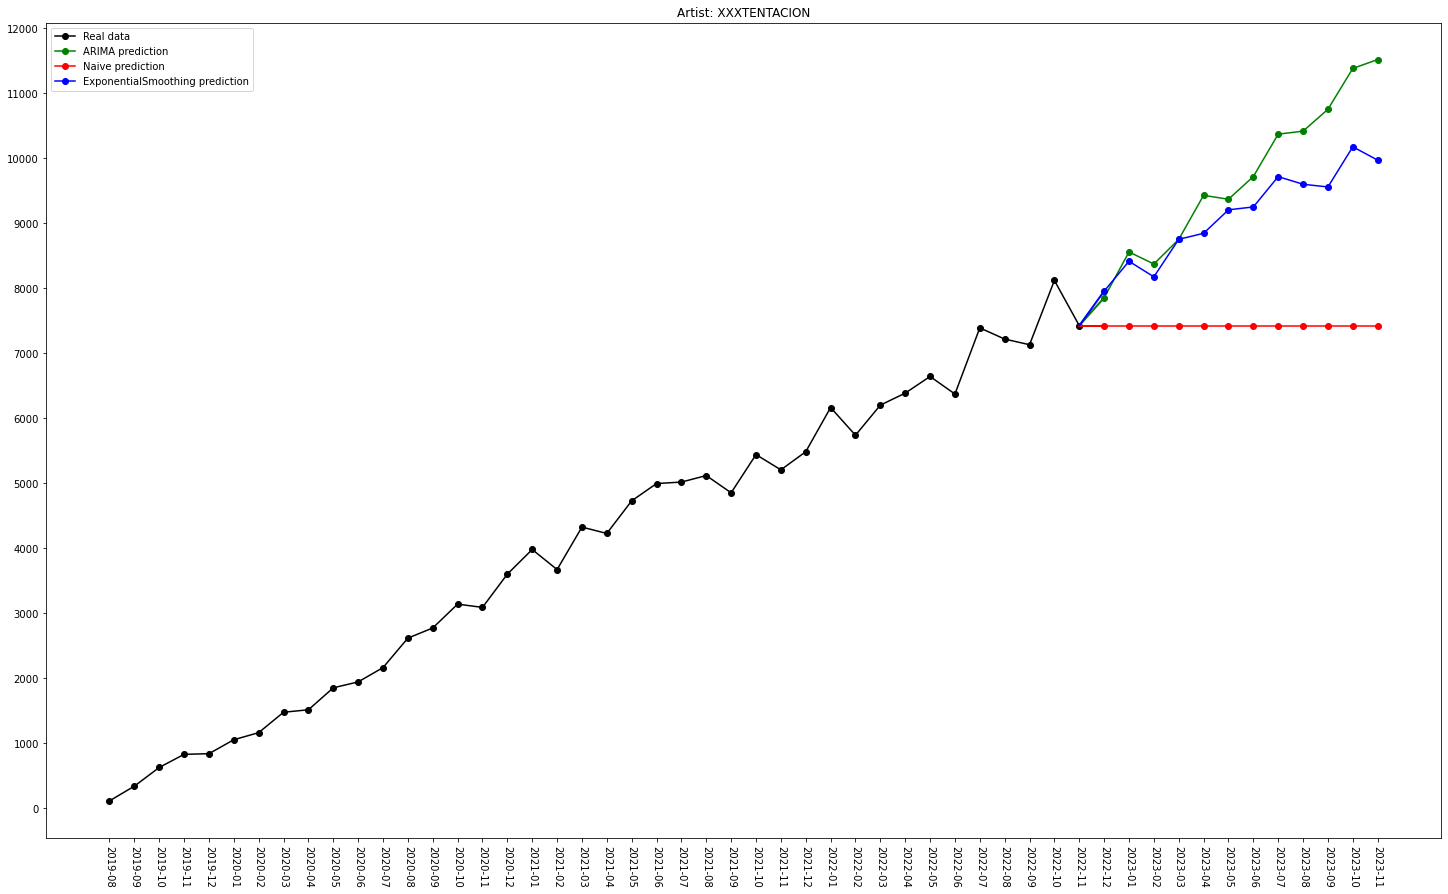

In [38]:
plt.title(f"Artist: {ARTIST}")
plt.locator_params(axis='y', nbins=20)
plt.xticks(rotation=270)


# real data nad predicitons from models
plt.plot(data, label="Real data" ,marker='o', color='black')
plt.plot(data_arima_predicted,marker='o', label="ARIMA prediction", color='green')
plt.plot(data_naive_predictions,marker='o', label="Naive prediction", color='red')
plt.plot(data_es_preditions,marker='o', label="ExponentialSmoothing prediction", color='blue')

# connection between real data and predicted data
plt.plot([data.index[-1], data_arima_predicted.index[0]], [data[-1], arima_predictions[0]], color='green', linestyle='-', linewidth=2)
plt.plot([data.index[-1], data_naive_predictions.index[0]], [data[-1], naive_predictions[0]], color='red', linestyle='-', linewidth=2)
plt.plot([data.index[-1], data_es_preditions.index[0]], [data[-1], es_predictions[0]], color='blue', linestyle='-', linewidth=2)

plt.legend()
plt.show()

### Ocena jakości na podstawie ostatniego miesiąca z otrzymanych danych

In [39]:

last_known_month = data[-1]
real_growth = get_percent_growth(last_known_month, last_month[1])
arima_growth = get_percent_growth(last_known_month, arima_predictions[0])
ExponentialSmoothing_growth = get_percent_growth(last_known_month, es_predictions[0])
naive_growth = get_percent_growth(last_known_month, naive_predictions[0]) 

print(f"Real growth: {real_growth}")
print(f"ARIMA growth: {arima_growth}")
print(f"ExponentialSmoothing growth: {ExponentialSmoothing_growth}")
print(f"Naive growth: {naive_growth}")



arima_MSE_loss = calculate_MSE_loss(real_growth, arima_growth)
ExponentialSmoothing_MSE_loss = calculate_MSE_loss(real_growth, ExponentialSmoothing_growth)
naive_MSE_loss = calculate_MSE_loss(real_growth, naive_growth)

print(f"ARIMA MSE loss: {arima_MSE_loss}")
print(f"ExponentialSmoothing MSE loss: {ExponentialSmoothing_MSE_loss}")
print(f"Naive MSE loss: {naive_MSE_loss}")


Real growth: 7.029356315647724
ARIMA growth: 5.776432073040328
ExponentialSmoothing growth: 7.149900466021884
Naive growth: 0.0
ARIMA MSE loss: 1.569819157713316
ExponentialSmoothing MSE loss: 0.014530892189428098
Naive MSE loss: 49.411850212336546


## Wykonywanie predykcji dla artystów
Ilość artystów równa zmiennej RANDOM_ARITISTS_N
Jeśli ustawimy na MAX_ARTISTS to obliczy nam błędy dla wszystkich artystów

Aby sprawdzić, czy jest wielka różnica błędów dla bardzo popularnych, popularnych oraz niszowych artystów, podzieliliśmy artystów na 3 grupy według kryterium:

Liczba wysłuchań - L:
- L>10000 - bardzo popularni
- 10000>L>=1000 - popularni
- 1000>L - niszowi

In [27]:
very_popular_artists = []
popular_artists = []
nishe_artists = []

for artist in artist_clicks_dictionary:
    clicks_sum = sum(list(artist_clicks_dictionary[artist].values()))
    if clicks_sum > 10000:
        very_popular_artists.append(artist)
    elif clicks_sum < 1000:
        nishe_artists.append(artist)
    else:
        popular_artists.append(artist)

print(f"Number of very popular artists: {len(very_popular_artists)}")
print(f"Number of popular artists: {len(popular_artists)}")
print(f"Number of nishe artists: {len(nishe_artists)}")

Number of very popular artists: 230
Number of popular artists: 385
Number of nishe artists: 193


In [ ]:
import random
MAX_ARTISTS = 808
RANDOM_ARTISTS_N = MAX_ARTISTS

random.seed(41)
random_artists = random.sample(list(artist_clicks_dictionary.keys()), RANDOM_ARTISTS_N)

#change it to test different groups of artists
ARTISTS = nishe_artists

# predictions
arima_predictions = []
ExponentialSmoothing_predictions = []
real_values = []

# growth
real_growth = []
arima_growth = []
ExponentialSmoothing_growth = []
naive_growth = []

for artist in random_artists:
    data = deepcopy(artist_clicks_series[artist])
    last_month = data.popitem()
    month_to_predict = last_month[1]
    data = pd.Series(data)
    last_known_month = data[-1]

    #ARIMA
    arima_model = auto_arima(data, trend='t', max_d=3, max_P=3, max_Q=3, max_order=None, seasonal=True, frequency="MS", stepwise=True)
    arima_model.fit(data)

    arima_prediction = arima_model.predict(n_periods=1)[0]
    arima_predictions.append(arima_prediction)
    real_values.append(month_to_predict)
    
    # Exponential
    es_model = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
    es_model_fit = es_model.fit()
    es_predictions = es_model_fit.predict(start=len(data), end=len(data))
    ExponentialSmoothing_predictions.append(es_predictions[0])

    # Naive
    naive_model = NaiveModel(data)
    naive_prediction = naive_model.predict(1)
    naive_prediction = data[-1]

    # calculate percent growth
    real_growth.append(get_percent_growth(last_known_month, month_to_predict))
    arima_growth.append(get_percent_growth(last_known_month, arima_prediction))
    ExponentialSmoothing_growth.append(get_percent_growth(last_known_month, es_predictions[0]))
    naive_growth.append(get_percent_growth(last_known_month, naive_prediction))


    

In [29]:
arima_mse_loss = calculate_MSE_loss(np.array(real_growth), np.array(arima_growth))
ExponentialSmoothing_mse_loss = calculate_MSE_loss(np.array(real_growth), np.array(ExponentialSmoothing_growth))
naive_mse_loss = calculate_MSE_loss(np.array(real_growth), np.array(naive_growth))

print(f"MSE loss ARIMA: {arima_mse_loss}")
print(f"MSE loss ExponentialSmoothing: {ExponentialSmoothing_mse_loss}")
print(f"MSE loss naive: {naive_mse_loss}")

# print MAE loss
arima_mae_loss = calculate_MAE_loss(np.array(real_growth), np.array(arima_growth))
ExponentialSmoothing_mae_loss = calculate_MAE_loss(np.array(real_growth), np.array(ExponentialSmoothing_growth))
naive_mae_loss = calculate_MAE_loss(np.array(real_growth), np.array(naive_growth))

print(f"MAE loss ARIMA: {arima_mae_loss}")
print(f"MAE loss ExponentialSmoothing: {ExponentialSmoothing_mae_loss}")
print(f"MAE loss naive: {naive_mae_loss}")



MSE loss ARIMA: 275.56023907068936
MSE loss ExponentialSmoothing: 290.7795035053982
MSE loss naive: 498.60050277570275
MAE loss ARIMA: 10.552757408708842
MAE loss ExponentialSmoothing: 11.431984494178629
MAE loss naive: 15.074395269593158


## Porównanie wyników
Dla wszystkich artystów (808):

MSE:
- MSE LOSS ARIMA: 275.56023907068936 
- MSE LOSS ExponentialSmoothing: 290.7795035053982
- MSE LOSS naive: 498.60050277570275


MAE:
- MAE loss ARIMA: 10.552757408708842
- MAE loss ExponentialSmoothing: 11.431984494178629
- MAE loss naive: 15.074395269593158

Tylko dla artystów bardzo popularnych (230):

MSE:
- MSE loss ARIMA: 30.157875261113922
- MSE loss ExponentialSmoothing: 43.56777494710828
- MSE loss naive: 92.69533451559884


MAE:
- MAE loss ARIMA: 4.572736119532147
- MAE loss ExponentialSmoothing: 5.138337118504478
- MAE loss naive: 8.355715115405157

Tylko dla artystów popularnych(385):

MSE:
- MSE loss ARIMA: 145.15384149749318
- MSE loss ExponentialSmoothing: 154.13253925010937
- MSE loss naive: 287.63900565942123


MAE:
- MAE loss ARIMA: 9.114374815728134
- MAE loss ExponentialSmoothing: 9.68060568260426
- MAE loss naive: 13.183566883368645



Tylko dla artystów niszowych(193):

MSE:
- MSE loss ARIMA: 828.1457662307043
- MSE loss ExponentialSmoothing: 857.9700672706463
- MSE loss naive: 1403.1516172295485


MAE:
- MAE loss ARIMA: 20.548520076108908
- MAE loss ExponentialSmoothing: 22.425869151490478
- MAE loss naive: 26.8529722859645


| Błąd | Model                | Wszyscy     | Bardzo popularni | Popularni   | Niszowi      |
|------|----------------------|-------------|------------------|-------------|--------------|
| MAE  | ARIMA                | 10.55275741 | 4.57273612       | 9.114374816 | 20.54852008  |
| MAE  | ExponentialSmoothing | 11.43198449 | 5.138337119      | 9.680605683 | 22.42586915  |
| MAE  | naive                | 15.07439527 | 8.355715115      | 13.18356688 | 26.85297229  |
| MSE  | ARIMA                | 275.5602391 | 30.15787526      | 145.1538415 | 828.1457662  |
| MSE  | ExponentialSmoothing | 290.7795035 | 43.56777495      | 154.1325393 | 857.9700673  |
| MSE  | naive                | 498.6005028 | 92.69533452      | 287.6390057 | 1403.151617  |


### Wnioski ogólne
Z porównania modeli wynika, że ARIMA poradziła sobie z tym problemem lepiej od ExponentialSmoothing i naiwnego modelu. W implementacji naszego modelu zostanie uzyta ARIMA oraz model naiwny.

### Wnioski da wyników zależnych od popularności artysty
Wyraźnie widać, że zaprezentowane modele o wiele lepiej radzą sobie z przewidzeniem wartości procentowej zmiany popularności bardzo popularnych artystów, dla tej grupy właśnie można powiedzieć, iż spełnione zostało kryterium sukcesu. Im mniej popularny artysta, tym coraz słabiej modele radzą sobie z przewidzeniem zmiany ich popularności, dla niszowych artystów, nie ma większej różnicy czy wykorzystany został model ARIMA czy naiwny. Będąc świadomym kontekstu biznesowego sytuacji, zdaje się, że najważniejszym jest przewidywanie wartości dla bardzo popularnych artystów - to oni przynoszą największe przychody, oraz otrzymują największe wynagrodzenie. 

Słaba możliwość predykcji zwiększenia się popularności dla niszowych artystów jest również spowodowana tym, iż co niektórzy zyskiwali bardzo małą liczbę kliknięć w ciągu miesiąca. Mimo że w przypadku wszystkich artystów widać trend rosnący, to dla bardzo niszowych artystów (z kliknięciami rzędu 10 - 100 w miesiącu/500 użytkowników) wahania popularności są nieregularne, a czasami wręcz niemożliwe do przewidzenia. 

Na szczęście, zważając na kontekst portalu, najważniejsze jest to, aby poprawnie przewidywać zmiany w popularności najbardziej popularnych artystów. Z tym zadaniem, nasz model radzi sobie bardzo dobrze, średnio myli się o +/- 4.5%.



## Exportowanie modeli dla wszystkich artystów

In [ ]:
import pickle
arima_models = {}
naive_models = {}


for artist in artist_clicks_dictionary.keys():
    data = deepcopy(artist_clicks_series[artist])
    last_month = data.popitem()
    month_to_predict = last_month[1]
    data = pd.Series(data)
    last_known_month = data[-1]

    #ARIMA
    arima_model = auto_arima(data, trend='t', max_d=3, max_P=3, max_Q=3, max_order=None, seasonal=True, frequency="MS", stepwise=True)
    arima_model.fit(data)

    arima_prediction = arima_model.predict(n_periods=1)[0]
    arima_predictions.append(arima_prediction)
    real_values.append(month_to_predict)

    # Naive
    naive_model = NaiveModel(data)

    arima_models[artist] = arima_model
    naive_models[artist] = naive_model


# export arima models do pickle
with open('arima_models.pickle', 'wb') as handle:
    pickle.dump(arima_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

# export naive models do pickle
with open('naive_models.pickle', 'wb') as handle:
    pickle.dump(naive_models, handle, protocol=pickle.HIGHEST_PROTOCOL)


    

## Jak wydobyć modele z pickle (sanity check)

In [31]:
with open('arima_models.pickle', 'rb') as handle:
    arima_models = pickle.load(handle)

arima_pred = arima_models['The Beatles'].predict(n_periods=1)
print(arima_pred)


with open('naive_models.pickle', 'rb') as handle:
    naive_models = pickle.load(handle)

naive_pred = naive_models['The Beatles'].predict(1)
print(naive_pred)

#działa

[2810.09494504]
2673


In [47]:
# export artists to txt
with open('artists.txt', 'w') as f:
    for item in artist_clicks_dictionary.keys():
        f.write(f"{item}\n")

    

## Wnioski koncowe

Udało nam się wykonać predykcje stosując model ARIMA oraz naiwny. Modele te dają najlepsze predykcje dla artystów bardzo popularnych, im mniej popularny dany artysta, tym ciężej przewidzieć jego wzrost popularności z miesiąca na miesiąc.